![logo](../../LogoLine_horizon_C3S.png)

<div class="alert alert-block alert-warning">
Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch
</div>

# Time consistency of ERA5 for detecting the footprint of climate change in the atmosphere

Production date: 30-08-2024

Produced by:  Sandro Calmanti (ENEA), Alessandro Dell'Aquila(ENEA)

## 🌍 Use case:  Assessing the impact of volcanic eruptions on the upper atmosphere in the 20th century

## ❓ Quality assessment question
* **How well does ERA5 represent the footprint of major volcanic eruptions in the vertical structure of the atmosphere?**

ERA5 is the global climate reanalysis dataset produced by the European Centre for Medium-Range Weather Forecasts (ECMWF), providing hourly estimates of a wide range of atmospheric, land, and oceanic climate variables from 1940 to the present [[1]]( https://doi.org/10.1002/qj.4803) [[2]]( https://doi.org/10.1002/qj.3803). Compared to previous ECMWF reanalyses (ERA, ERA-40, ERA-Interim), ERA5 extends further back to 1940, well before the availability of satellite observations, which provide essential information on the three-dimensional structure of the atmosphere.

This notebook provides an overview of the long-term consistency of ERA5 by examining the mean vertical structure of key atmospheric parameters and their relation with major volcanic eruptions.

As an example, the figure below illustrates the temperature impact of the 1991 eruption of Mt. Pinatubo, highlighting the subsequent warming of the lower stratosphere.

```{figure} 341c63c4-0f71-4fe5-bfdc-15e25ba2f53f.png
---
height: 300px
---
ADD FIGURE CAPTION
```

## 📢 Quality assessment statements

```{admonition} These are the key outcomes of this assessment
:class: note
* ERA5 provides physically consistent information on the expected impact of major volcanic eruptions on the climate system, both in the stratosphere and in the troposphere.
* Prior to 1979, and particularly during the first two decades of ERA5 from 1940 to 1960, the main mechanisms of stratospheric variability is not consistent with the expected behavior of the quasi-biennial oscillation. Data from the upper stratosphere during the early years of the reanalysis should be treated carefully.
* ERA5 is punctuated by discontinuities in the upper stratosphere, due to the introduction of different satellite observations.
* After 2006, with the introduction of radio occultation data, discontinuities in the upper stratosphere are significantly reduced.


## 📋 Methodology 

The analysis uses [ERA5 monthly averaged data on pressure levels from 1940 to present](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-pressure-levels-monthly-means?tab=overview) available on the Copernicus Data Store and consists of three simple steps.

**[](reanalysis_reanalysis-era5-pressure-levels-monthly-means_consistency-assessment_q01:template:section-1)**

**[](reanalysis_reanalysis-era5-pressure-levels-monthly-means_consistency-assessment_q01:template:section-2)**
 * Get the data
 * Compute monthly anomalies

**[](reanalysis_reanalysis-era5-pressure-levels-monthly-means_consistency-assessment_q01:template:section-3)**
 * Temperature
 * U-component of the wind
 * Vertical velocity
 * Ozone mixing ratio
 * Relative humidity
 * Fraction of cloud cover

## 📈 Analysis and results

(reanalysis_reanalysis-era5-pressure-levels-monthly-means_consistency-assessment_q01:template:section-1)=
### 1. Set-up of the analysis

We use only standard Python modules for this notebook. In particular `numpy` is necessary to handle the dates of volcanic eruptions.

The data employed for the analysis include:

* 6 variables summarizing key dynamic, thermodynamic and chemical aspects of the state of the atmosphere;
* the whole time span of ERA5, from 1940 to the present;
* all 37 pressure levels of ERA5 available on the Climate Data Store (NOTE: the ECMWF Integrated Forecasting System underpinning the production of ERA5 uses [137 pressure levels](https://confluence.ecmwf.int/display/UDOC/L137+model+level+definitions) )

The major volcanic eruptions of the XX century with a Volcanic Explosivity Index ([VEI](https://www.usgs.gov/observatories/yvo/news/volcanic-explosivity-index-a-tool-comparing-sizes-explosive-volcanic)) greater than 5 are included in the analysis. The approximate date of the eruptions and the corresponding VEI are taken from the catalogue of the [Smithsonian Institution - National Museum of National History](https://volcano.si.edu/). The eruptions of Mount St. Helens El Chichón occurred in 1980 and 1982 respectively. However, for the sake of simplicity they are both attributed to 1981 in the list below.

**NOTE**: the units of the vertical pressure levels are converted from Pascal (Pa) to hecto-Pascal (hPa), which is equivalent to millibars (mb).

In [1]:
#__________________
# Setup environment
#__________________

import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from c3s_eqc_automatic_quality_control import diagnostics, download

os.environ["CDSAPI_RC"] = os.path.expanduser("~/calmanti_sandro/.cdsapirc")

#____________________
# Define data request
#____________________

collection_id = "reanalysis-era5-pressure-levels-monthly-means"

start = "1940-01"
stop = None  # None: present

variables = [
    "temperature",
    "u_component_of_wind",
    "vertical_velocity",
    "relative_humidity",
    "fraction_of_cloud_cover", 
]

pressure_levels = ["1","2","3","5","7","10","20","30","50","70","100","125","150","175","200","225","250","300","350","400",
                   "450","500","550","600","650","700","750","775","800","825","850","875","900","925","950","975","1000"]

# Volcanic eruptioin dates
# Solid line for VEI=6
# Dashed line for VEI=5
eruptions = {
    'eruption1': {
        'volcano': 'Pinatubo',
        'date': np.datetime64('1991-06-15'),
        'linestyle': '-'
    },
    'eruption2': {
        'volcano': 'El Chichón, Mount St. Helens',
        'date': np.datetime64('1981-01-01'),
        'linestyle': '--'  
    },
    'eruption3': {
        'volcano': 'Agung',
        'date': np.datetime64('1963-02-24'),
        'linestyle': '-'
    },
    'eruption4': {
        'volcano': 'Bezymianny',
        'date': np.datetime64('1956-01-01'),
        'linestyle': '--'
    },
    # Add more eruptions as needed
}

(reanalysis_reanalysis-era5-pressure-levels-monthly-means_consistency-assessment_q01:template:section-2)=
### 2. Data retrieval and processing

#### Get the data
For this analysis, we use a very simple processing (spatially weighted mean over the whole grid) applied to a selected set of atmospheric variables. 

Monthly averaged data on pressure levels are retrieved for temperature, U-component of the wind, vertical velocity, ozone mass mixing ratio, relative humidity and cloud cover for the period 1940 to present on all available pressure levels.
The spatially weighted mean of each variable is computed using a built in transformation function. 

In [ ]:
#_______________
# Retrieve data
#_______________

datasets = []
for variable in variables:
    print(f"Downloading and processing {variable}")
    #Define a general request
    request = {
     "format": "grib",
     "product_type": "monthly_averaged_reanalysis",
     "variable": variable,
     "pressure_level": pressure_levels ,
     "time": "00:00",
    }
    #Update the request dictionary to include all dates between start and stop
    requests = download.update_request_date(request, start=start, stop=stop)
    
    ds = download.download_and_transform(
      collection_id,
      requests,
      transform_func=diagnostics.spatial_weighted_mean,
      chunks={"year": 1}
    )
    datasets.append(ds)
ds_era5 = xr.merge(datasets)

#Convert plev to hPa (mb)
ds_era5["plev"] = ds_era5["plev"]/100
ds_era5["plev"].attrs.update({"long_name": "Level", "units": "hPa"})

#### Compute monthly anomalies

The next step is to calculate the difference between the monthly vertical profiles of each variable and the corresponding monthly climatology.

In [3]:
#Compute anomalies
with xr.set_options(keep_attrs=True):
    ds_anoma = ds_era5.groupby("forecast_reference_time.month") - ds_era5.groupby("forecast_reference_time.month").mean("forecast_reference_time")
    for varname in list(ds_anoma.data_vars):
      ds_anoma[varname].attrs["long_name"] = ds_era5[varname].attrs["long_name"] + " anomaly"
      print(f"{varname} min.:{ds_anoma[varname].min().values}  max:{ds_anoma[varname].max().values}")

t min.:-6.438390370217974  max:11.038073943643667
u min.:-22.757888895140646  max:24.359026856962068
w min.:-0.0011010774476719158  max:0.0011456845175556556
r min.:-5.264730876113122  max:8.222526696011663
cc min.:-0.014970516138825829  max:0.011787966068033423


(reanalysis_reanalysis-era5-pressure-levels-monthly-means_consistency-assessment_q01:template:section-3)=
### 3. Results for key atmospheric variables

For all variables listed above, we show the Hovmöller diagram, which illustrates the monthly anomalies compared to the corresponding monthly climatology (see figure below).

The colour ranges are carefully chosen to emphasise the main features of the long-term variability. We ensure that each variable is shown with an appropriate vertical scale, effectively highlighting the range where most of the variability occurs.

To illustrate the significant variability in the stratosphere, we use a logarithmic vertical scale for temperature, U-component of the wind, geopotential height and ozone mixing ratio. Conversely, we use a linear vertical scale for vertical velocity, humidity, and cloud fraction, since most of the variability is concentrated in the troposphere. The vertical lines on the graphs indicate the timing of significant volcanic eruptions.

The figures show key aspects of global-scale atmospheric variability and change, while highlighting the role of volcanic eruptions and some possible artefacts due to the increasing density of data in the stratosphere between 1940 and 1979 and the introduction of satellite observations after 1979.

The figures below show significant aspects of global-scale atmospheric variability and change, while also highlighting the role of volcanic eruptions and some potential artifacts originating from an increasing density of data in the stratosphere during the period 1940 and 1979 and the introductions of satellite observations after 1979.

#### Temperature
For temperature, the figures clearly show long-term tropospheric warming and stratospheric cooling trends associated with anthropogenic climate change. The stratospheric warming following the major volcanic eruptions is consistent in magnitude with direct measurements of lower stratospheric warming from the Microwave Sounding Unit (MSU) [[2]]( https://doi.org/10.1029/2004JD005075). The cooling of the stratosphere following the transient warming after the Pinatubo eruption is consistent with the reduced stratospheric ozone concentration  discussed by [[3]](https://doi.org/10.1175/2008JCLI2482.1). The discontinuities in the upper stratosphere are related to the introduction of different satellite observations into the data assimilation system [[4]](https://doi.org/10.1002/qj.4174). In particular, the stabilisation of the discontinuities after 2006 corresponds to the assimilation of a large number of radio occultation data in the reanalysis.

#### U-component of the wind
With respect to the U-component of the wind, the variability is dominated by the Quasi-Biennial Oscillation (QBO) in the stratosphere [[5]](https://doi.org/10.1029/1999RG000073), with a negligible effect of volcanic eruptions, while no significant global-scale pattern is discernible in the troposphere below 100 hPa. During the first two decades of the reanalysis (1940-1960), the stratospheric variability associated with the QBO is markedly weaker compared to the subsequent period, consistent with the larger variance of the ensemble data assimilation [[4]](https://doi.org/10.1002/qj.4174).

#### Vertical velocity
The effect of volcanic eruptions on vertical velocity in the troposphere is negligible. However, the discernible long-term trend in vertical velocity, which is represented in the vertical velocity panel with the transition from mostly positive to mostly negative anomalies after year 2000, has been attributed it to the enhanced  atmospheric deep convection over the tropical western Pacific [[6]](https://doi.org/10.5194/acp-22-4393-2022). Note that a negative vertical velocity anomaly expressed in $Pa/s$ is equivalent to a positive anomaly expressed in $m/s$.

#### Relative humidity
Relative humidity shows a marked decrease in tropospheric water vapour, as expected following major volcanic the eruptions as in the case of Mt. Pinatubo [[7]](https://doi.org/10.1126/science.296.5568.727).

#### Fraction of cloud cover
The fraction of cloud cover does not exhibit a direct global response to major volcanic eruptions. Instead, it is marked by a notable shift in the upper troposphere coinciding with the introduction of satellite observations into assimilation systems after 1979. In recent decades, ERA5 indicates a reduction in low-level clouds (as shown by the negative anomalies in the bottom panel), consistent with the observed decline in cloud amount at mid-latitudes in both hemispheres. This trend is supported by analyses of the International Satellite Cloud Climatology Project (ISCCP) dataset, the Extended Pathfinder Atmospheres (PATMOS-x) dataset, and data from the Earth Radiation Budget Satellite. [[8]](https://doi.org/10.1038/nature18273).

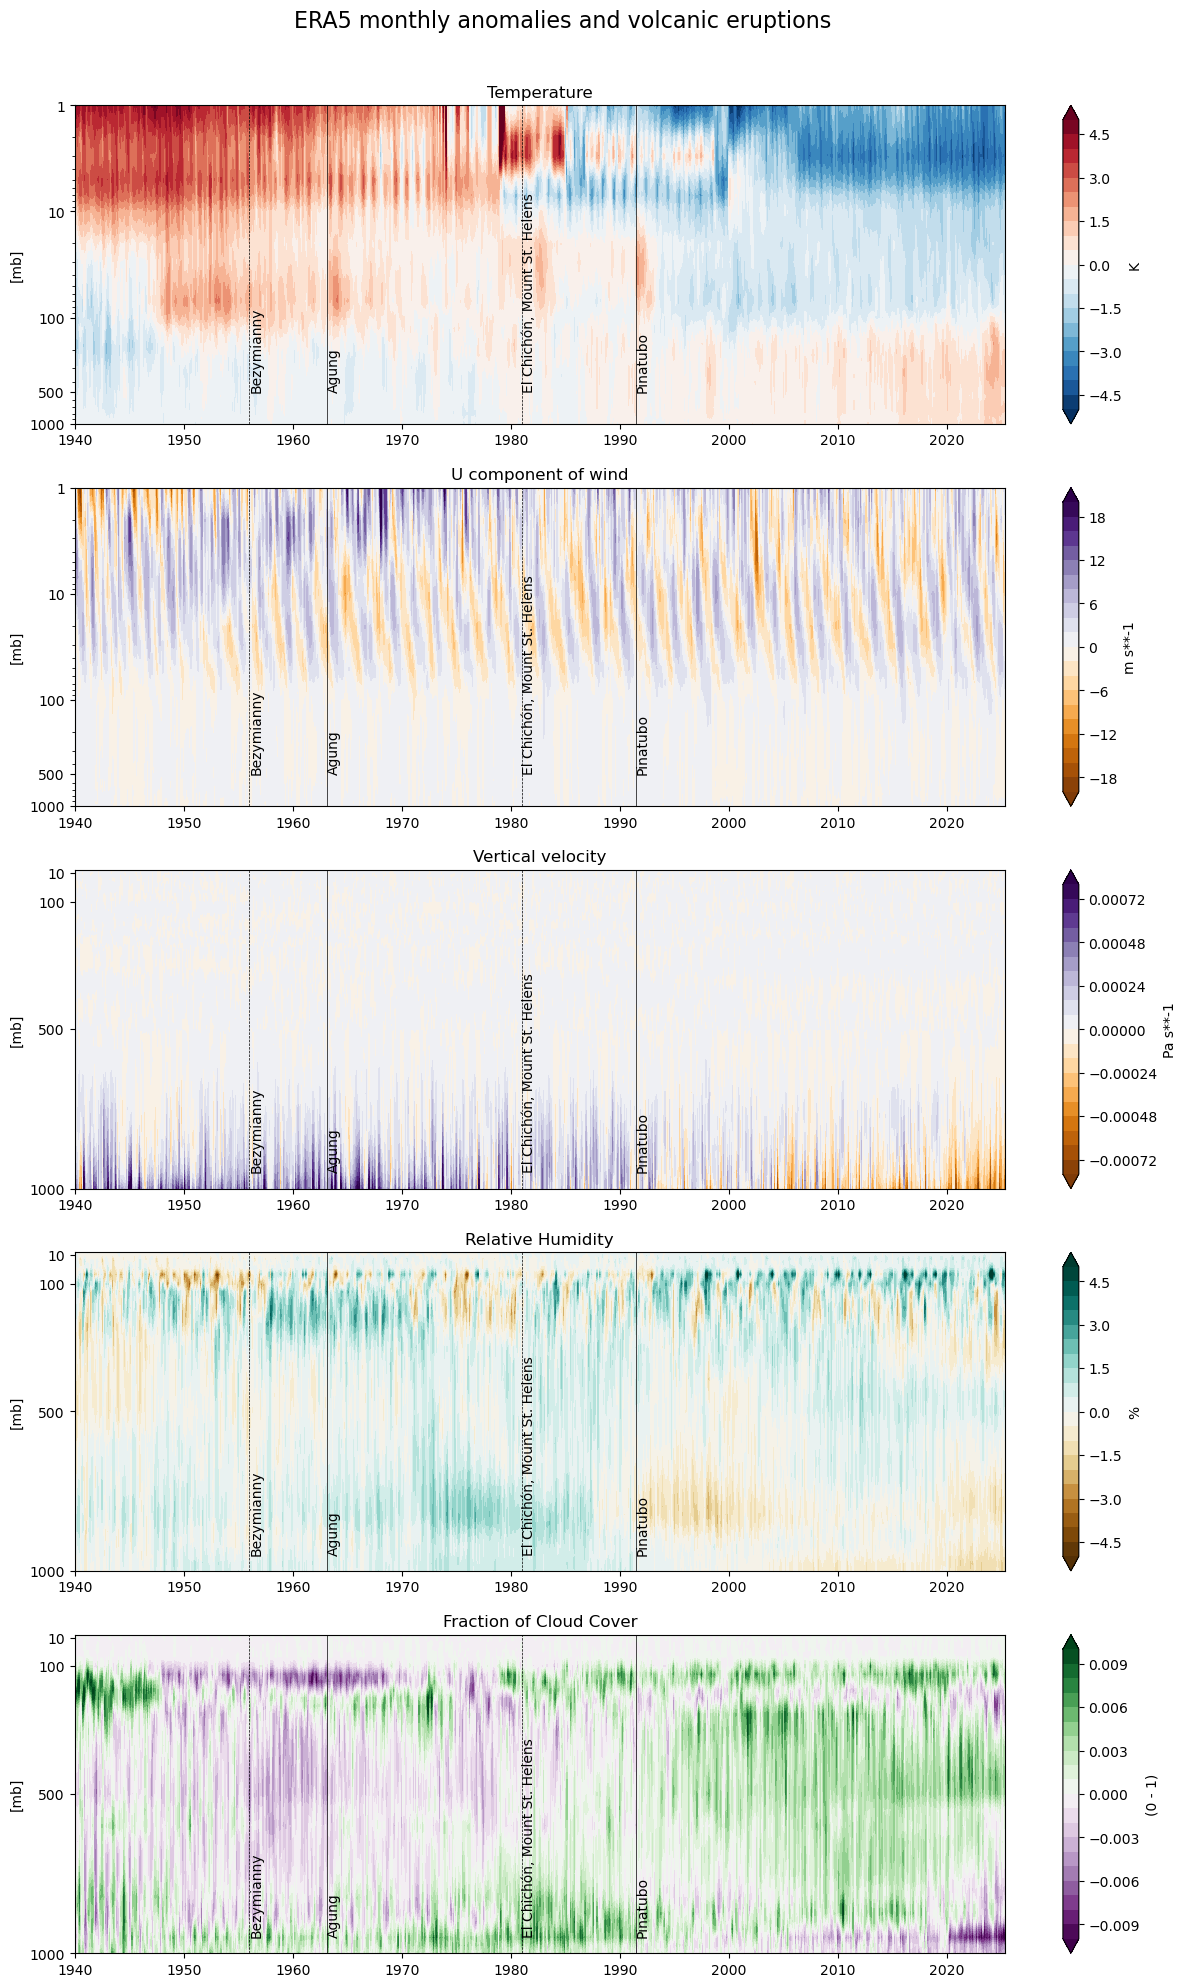

In [4]:
#Set time interval to display
#xlim=np.array(['1988-01-01','1995-12-31'], dtype='datetime64') # zoom on Pinatubo
#xlim=np.array(['1962-01-01','1967-12-31'], dtype='datetime64') # zoom on Agung
#xlim=np.array(['1980-01-01','1985-12-31'], dtype='datetime64') # zoom on El Chicon
xlim=np.array(['1940-01-01','2022-12-31'], dtype='datetime64') # entire period
        
#Define customized configuration for each variable
toplot = {
    "Temperature" : {
       "vname"   : "t",
       "levels"  : np.arange(-5, 5.5, 0.5),
       "yscale"  : "log",
       "ylim"    : [1000, 1],
       "yticks"  : [1000,500,100,10,1],
       "cmap"    : "RdBu_r"
    },
    "U component of wind" : {
       "vname"   : "u",
       "levels"  : np.arange(-20, 20+2, 2),
       "yscale"  : "log",
       "ylim"    : [1000, 1],
       "yticks"  : [1000,500,100,10,1],
       "cmap"    : "PuOr"
    },
    "Vertical velocity" : {
       "vname"   : "w",
       "levels"  : np.arange(-0.8e-3, 0.8e-3+0.8e-4, 0.8e-4),
       "yscale"  : "linear",
       "ylim"    : [1000, 10],
       "yticks"  : [1000,500,100,10],
       "cmap"    : "PuOr"
    },
    "Relative Humidity" : {
       "vname"   : "r",
       "levels"  : np.arange(-5, 5+0.5, 0.5),
       "yscale"  : "linear",
       "ylim"    : [1000, 10],
       "yticks"  : [1000,500,100,10],
       "cmap"    : "BrBG"
    },
    "Fraction of Cloud Cover" : {
       "vname"   : "cc",
       "levels"  : np.arange(-0.01, 0.01+0.001, 0.001),
       "yscale"  : "linear",
       "ylim"    : [1000, 10],
       "yticks"  : [1000,500,100,10],
       "cmap"    : "PRGn"
    },
}

fig, axs = plt.subplots(len(toplot))

for i, (varname,attr) in enumerate(toplot.items()):    
    cf = axs[i].contourf(ds_anoma["forecast_reference_time"],ds_anoma["plev"],
                         ds_anoma[attr["vname"]].transpose("plev","forecast_reference_time"),
                         cmap=attr["cmap"],extend='both',levels=attr["levels"])
    axs[i].set_yscale(attr["yscale"])
    axs[i].set_yticks(attr["yticks"])
    axs[i].set_title(varname)
    axs[i].yaxis.set_major_formatter(ScalarFormatter())
    axs[i].invert_yaxis()
    axs[i].set_ylabel('[mb]')
    axs[i].set_xlabel("")
    fig.colorbar(cf, ax=axs[i], label=ds_anoma[attr["vname"]].attrs["units"]) 
    # Add volcanic eruptions
    for eruption_name, eruption in eruptions.items():   
        eruption_date = eruption['date']
        linestyle = eruption['linestyle']
        volcano_name = eruption['volcano']
        if eruption_date >= xlim[0] and eruption_date <= xlim[1]:
           axs[i].axvline(eruption_date, color='black', linestyle=linestyle, lw=0.5)
           axs[i].text(eruption_date, 1000. - 500./(attr['ylim'][1]), volcano_name, rotation='vertical', ha='left', va='bottom')
       
fig.suptitle('ERA5 monthly anomalies and volcanic eruptions', fontsize=16, x=0.45, y=0.92)    
fig.set_size_inches(15,24)

## ℹ️ If you want to know more

A more detailed analysis global temperature response to the major volcanic eruptions has been conducted by comparing different reanalysis products, including an earlier generation of the ECMWF reanalysis ERA40 [[1]](https://doi.org/10.5194/acp-15-13507-2015).

### Key resources
This notebook uses [ERA5 monthly averaged data on pressure levels from 1940 to present](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-pressure-levels-monthly-means?tab=overview) available on the Climate Data Store.

A comprehensive catalog of volcanic eruptions is currently (i.e. last updated June 2025) through the [Global Volcanism Program, 2024. Volcanoes of the World (v. 5.2.8; 6 May 2025). Distributed by Smithsonian Institution, compiled by Venzke, E.](https://doi.org/10.5479/si.GVP.VOTW5-2024.5.2)

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)

### References

[[1]]( https://doi.org/10.1002/qj.4803) Soci, C., Hersbach, H., Simmons, A., Poli, P., Bell, B., Berrisford, P., ... & Thépaut, J. N. (2024). The ERA5 global reanalysis from 1940 to 2022. Quarterly Journal of the Royal Meteorological Society, 150(764), 4014-4048.

[[2]]( https://doi.org/10.1002/qj.3803) Hersbach, H., Bell, B., Berrisford, P., Hirahara, S., Horányi, A., Muñoz‐Sabater, J., ... & Thépaut, J. N. (2020). The ERA5 global reanalysis. Quarterly journal of the royal meteorological society, 146(730), 1999-2049.

[[3]](https://doi.org/10.1029/2004JD005075) Santer, B.D.,Wigley, T.M.L., Simmons, A.J., Kållberg, P.W., Kelly, G.A., Uppala, S.M., Ammann, C., Boyle, J.S., Brüggemann, W., Doutriaux, C., Fiorino, M., Mears, C., Meehl, G.A., Sausen, R., Taylor, K.E., Washington, W.M., Wehner, M.F., and Wentz, F.J., 2004: Identification of anthropogenic climate change using a second-generation reanalysis. J. Geophys. Res., 109, D21104, doi:10.1029/2004JD005075.

[[4]](https://doi.org/10.1175/2008JCLI2482.1) Thompson, D. W., & Solomon, S. (2009). Understanding recent stratospheric climate change. Journal of Climate, 22(8), 1934-1943.

[[5]](https://doi.org/10.1002/qj.4174) Bell, B., Hersbach, H., Simmons, A., Berrisford, P., Dahlgren, P., Horányi, A., ... & Thépaut, J. N. (2021). The ERA5 global reanalysis: Preliminary extension to 1950. Quarterly Journal of the Royal Meteorological Society, 147(741), 4186-4227.

[[6]](https://doi.org/10.1029/1999RG000073) Baldwin, M. P., Gray, L. J., Dunkerton, T. J., Hamilton, K., Haynes, P. H., Randel, W. J., ... & Takahashi, M. (2001). The quasi‐biennial oscillation. Reviews of Geophysics, 39(2), 179-229.

[[7]](https://doi.org/10.5194/acp-22-4393-2022) Qie, K., Wang, W., Tian, W., Huang, R., Xu, M., Wang, T., & Peng, Y. (2022). Enhanced upward motion through the troposphere over the tropical western Pacific and its implications for the transport of trace gases from the troposphere to the stratosphere. Atmospheric Chemistry and Physics, 22(7), 4393-4411.

[[8]](https://doi.org/10.1126/science.296.5568.727) Soden, B. J., Wetherald, R. T., Stenchikov, G. L., & Robock, A. (2002). Global cooling after the eruption of Mount Pinatubo: A test of climate feedback by water vapor. science, 296(5568), 727-730.

[[9]](https://doi.org/10.1038/nature18273) Norris, J. R., Allen, R. J., Evan, A. T., Zelinka, M. D., O’Dell, C. W., & Klein, S. A. (2016). Evidence for climate change in the satellite cloud record. Nature, 536(7614), 72-75.